### 导入包

In [ ]:
import sys
sys.path.append("..")
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from utils.PDE_Net import DeepONet_NS, FNO2d, weight_init
from utils.DataGenerate_FNO import Dataset_FNO, Normalize, InNormalize
from torch.utils.tensorboard import SummaryWriter
from utils.utilities3 import *

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
sys.path

定义超参数

In [ ]:
modes = 12
width = 100
dx = 0.5
n_x = int(8/dx)
n_y = int(3/dx)
p_x = int(800/n_x+1)
p_y = int(300/n_y+1)
self_split = 2

epochs = 1000
step_size = 50

batch_size = 300
learning_rate = 0.001
iterations = 2*epochs
max_norm = 5

n_train = 300
n_test = 100

path_trained_model = r'FNO/trained_model'

path_distance = r'train_data/distance'
path_label = r'train_data/label'

path_distance_test_name = r'distance_test.npy'
path_label_test_name = r'label_test.npy'
path_distance_test = r'test_data'
path_label_test = r'test_data'

#### 加载数据

In [ ]:
train_distance = torch.empty(0, p_x, p_y, 3)
train_label = torch.empty(0, p_x, p_y, 1)
file_list = os.listdir(path_distance)
for file in file_list:
	if file.endswith('.npy'):
			distance = np.load(os.path.join(path_distance, file))
			train_distance = torch.cat((train_distance, torch.Tensor(distance)), 0)
file_list = os.listdir(path_label)
for file in file_list:
	if file.endswith('.npy'):
			label = np.load(os.path.join(path_label, file))
			train_label = torch.cat((train_label, torch.Tensor(label)), 0)

test_distance = np.load(os.path.join(path_distance_test, path_distance_test_name))
test_label = np.load(os.path.join(path_label_test, path_label_test_name))

train_distance = torch.Tensor(train_distance)
train_label = torch.Tensor(train_label)
test_distance = torch.Tensor(test_distance)
test_label = torch.Tensor(test_label)

print(train_distance.shape)
print(train_label.shape)
print(test_distance.shape)
print(test_label.shape)

#### 归一化

In [ ]:
x_normalizer = GaussianNormalizer(train_distance)
x_data = x_normalizer.encode(train_distance)
y_normalizer = GaussianNormalizer(train_label)
y_data = y_normalizer.encode(train_label)

x_normalizer_test = GaussianNormalizer(test_distance)
x_test = x_normalizer_test.encode(test_distance)
y_normalizer_test = GaussianNormalizer(test_label)
y_test = y_normalizer_test.encode(test_label)

定义网络、优化器、损失函数、学习率衰减策略

In [3]:
model = FNO2d(modes,modes,width)
model.apply(weight_init)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
myloss = nn.MSELoss()

writer = SummaryWriter(r'runs\transtant_model')
begin_epoch = 0

unkown layer: SpectralConv2d()
unkown layer: SpectralConv2d()
unkown layer: SpectralConv2d()
unkown layer: SpectralConv2d()
unkown layer: Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
unkown layer: Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
unkown layer: MLP(
  (mlp1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (mlp2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
)
unkown layer: Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
unkown layer: Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
unkown layer: MLP(
  (mlp1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (mlp2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
)
unkown layer: Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
unkown layer: Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
unkown layer: MLP(
  (mlp1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (mlp2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
)
unkown layer: Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
unkow

加载模型

In [ ]:
file_list = os.listdir(path_trained_model)
if len(file_list) > 0:
	last_model = os.listdir(path_trained_model)[-1]
# save_path = os.path.join(path, 'model_{}.pth'.format(begin_epoch))
load_path = os.path.join(path_trained_model, last_model)
begin_epoch = load_model(load_path, optimizer, model)
model.to(device)

加载数据

In [3]:
train_loader = DataLoader(torch.utils.data.TensorDataset(x_data, y_data), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

x, y = next(iter(train_loader))
print(torch.max(x))
print(torch.max(y))

开始训练

In [81]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, verbose=True, min_lr=1e-6)
# epochs = 50000
for epoch in range(begin_epoch,epochs):
	model.train()
	train_loss_epoch = 0
	test_loss_epoch = 0
	for batch in train_loader:

		loss_train = 0
		data_x,data_y = batch

		x = data_x.float().to(device)			# [length,time_step,51,51,3]
		y = data_y.float().to(device)			# [length,time_step,51,51,3]

		pred = model(x)												# x:[length,51,51,3], pred:[length,51,51,3]
		
		pred = y_normalizer.decode(pred)
		y = y_normalizer.decode(y)
		
		loss_train = myloss(pred.clone(), y.clone())
			
		optimizer.zero_grad()
		train_loss_epoch = train_loss_epoch + loss_train.item()
		loss_train.backward(retain_graph=True)
		torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
		optimizer.step()
		# print('epoch:', epoch, 'loss_train:', loss_train.item())
	train_loss_epoch = train_loss_epoch / len(train_loader)
	print('epoch:', epoch, 'loss_train:', train_loss_epoch)
	scheduler.step(train_loss_epoch)
	
	model.eval()
	with torch.no_grad():
		for batch_test in test_loader:

			loss_test = 0
			test_x,test_y = batch_test
			
			test_x = test_x.float().to(device)			# [length,time_step,51,51,3]
			test_y = test_y.float().to(device)			# [length,time_step,51,51,3]

			pred_test = model(test_x)

			pred_test = y_normalizer_test.decode(pred_test)
			test_y = y_normalizer_test.decode(test_y)

			loss_test = myloss(pred_test.clone(), test_y.clone())

			test_loss_epoch = test_loss_epoch + loss_test.item()
		test_loss_epoch = test_loss_epoch/len(test_loader)
		print('epoch:', epoch, 'loss_test:', test_loss_epoch)

		# print('epoch:', epoch, 'loss_test:', loss_test.item())
	
	if epoch % 1000 == 0:
		save_path = os.path.join(path_trained_model, 'FNO_{}.pth'.format(epoch))
		save_model(save_path, epoch, optimizer, model)

		writer.add_scalar('loss_train', loss_train.item(), epoch)
		writer.add_scalar('loss_test', loss_test.item(), epoch)

	

### 测试(不需要了)

In [ ]:
clone = torch.load('model_full_data_2D_turbulence.pth')
clone.eval()
with torch.no_grad():
	u_pred = clone(test_bc[:,:,0],test_coordinates)
	v_pred = clone(test_bc[:,:,1],test_coordinates)
	p_pred = clone(test_bc[:,:,2],test_coordinates)
loss = loss_func(u_pred, test_variables[:,:,0]) + loss_func(v_pred, test_variables[:,:,1]) + loss_func(p_pred, test_variables[:,:,2])
print(loss.item())
u_pred = u_pred.cpu().detach().numpy().reshape(-1,51,51)
v_pred = v_pred.cpu().detach().numpy().reshape(-1,51,51)
p_pred = p_pred.cpu().detach().numpy().reshape(-1,51,51)
data = np.stack((u_pred,v_pred,p_pred),axis=3)
print(data.shape)

# 反归一化
inverse_data = dataset.inverse_normal(data,test_min,test_max)

查看测试集的准确率

In [ ]:
pred_index = 10
u_pred = inverse_data[pred_index,:,:,0]
v_pred = inverse_data[pred_index,:,:,1]
p_pred = inverse_data[pred_index,:,:,2]
print(u_pred.shape)

画预测图

In [ ]:
mag = np.sqrt(u_pred**2 + v_pred**2)
fig = plt.figure()
ax = fig.add_subplot(111)
contour = ax.contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag, 100, cmap='jet')
plt.colorbar(contour)
plt.show()

In [ ]:
print(train_variables.shape)

原始数据

In [ ]:
original_variables = test_variables.cpu().detach().numpy().reshape(-1,51,51,3)
original_data = dataset.inverse_normal(original_variables,test_min,test_max)
u_original = original_data[pred_index,:,:,0]
v_original = original_data[pred_index,:,:,1]
p_original = original_data[pred_index,:,:,2]

mag = np.sqrt(u_original**2 + v_original**2)
fig = plt.figure()
ax = fig.add_subplot(111)
contour = ax.contourf(train_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), train_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag, 100, cmap='jet')
plt.colorbar(contour)
plt.show()

误差图

In [ ]:
def error(pred,original):
	return np.sqrt((pred-original)**2)
u_error = error(u_pred,u_original)
v_error = error(v_pred,v_original)
p_error = error(p_pred,p_original)
mag_error = error(np.sqrt(u_pred**2 + u_pred**2),np.sqrt(u_original**2 + v_original**2))
print(u_error.shape)

In [ ]:
fig,axs = plt.subplots(1,4,figsize=(20,5))
axs[0].contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), u_error, 100, cmap='jet')
axs[1].contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), v_error, 100, cmap='jet')
axs[2].contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), p_error, 100, cmap='jet')
axs[3].contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag_error, 100, cmap='jet')
plt.colorbar(contour)
plt.show()

总误差

In [ ]:
def total_error(pred,original):
	return np.sqrt(np.mean((pred-original)**2))
u_tol_error = total_error(inverse_data[:,:,:,0],original_data[:,:,:,0])
v_tol_error = total_error(inverse_data[:,:,:,1],original_data[:,:,:,1])
p_tol_error = total_error(inverse_data[:,:,:,2],original_data[:,:,:,2])
mag_tol_error = total_error(np.sqrt(inverse_data[:,:,:,0]**2 + inverse_data[:,:,:,1]**2),np.sqrt(original_data[:,:,:,0]**2 + original_data[:,:,:,1]**2))

In [ ]:
print(u_tol_error)
print(v_tol_error)
print(p_tol_error)
print(mag_tol_error)

In [60]:
a = np.array([[1,2,3],[4,5,6]])
# [2,3]
b = np.mean(a,axis=0)
print(b)

[2.5 3.5 4.5]


### 拼接测试

variable测试

In [2]:
file = h5.File(r'I:\ML\Package_model\DeepONet\train_data\train_data_interval_10_split_1_FNO.h5','r')
print(file.keys())
print(file['x'].shape)

<KeysViewHDF5 ['x', 'y']>
(60, 96, 51, 51, 3)


In [3]:
data_dir = r'I:\ML\Package_model\DeepONet\train_data\transtant'
datafile = r'I:\ML\Package_model\DeepONet\train_data\train_data_interval_10_split_1_FNO.h5'
dataset = Dataset(data_dir,False,split=1,is_save=False,datafile=datafile)
# train_loader = DataLoader(dataset,batch_size=1,shuffle=False)
x,y = dataset.getitem()
time = 0
x = x.cpu().detach().numpy()[:,time,:,:,:]
y = y.cpu().detach().numpy()[:,time,:,:,:]

mag_x = np.sqrt(x[:,:,:,0]**2 + x[:,:,:,1]**2).reshape(-1,51,51)
mag_y = np.sqrt(y[:,:,:,0]**2 + y[:,:,:,1]**2).reshape(-1,51,51)
coordinate = np.meshgrid(np.linspace(0,0.5,51),np.linspace(0,0.5,51))
print(len(coordinate))

2


(96, 51, 51)


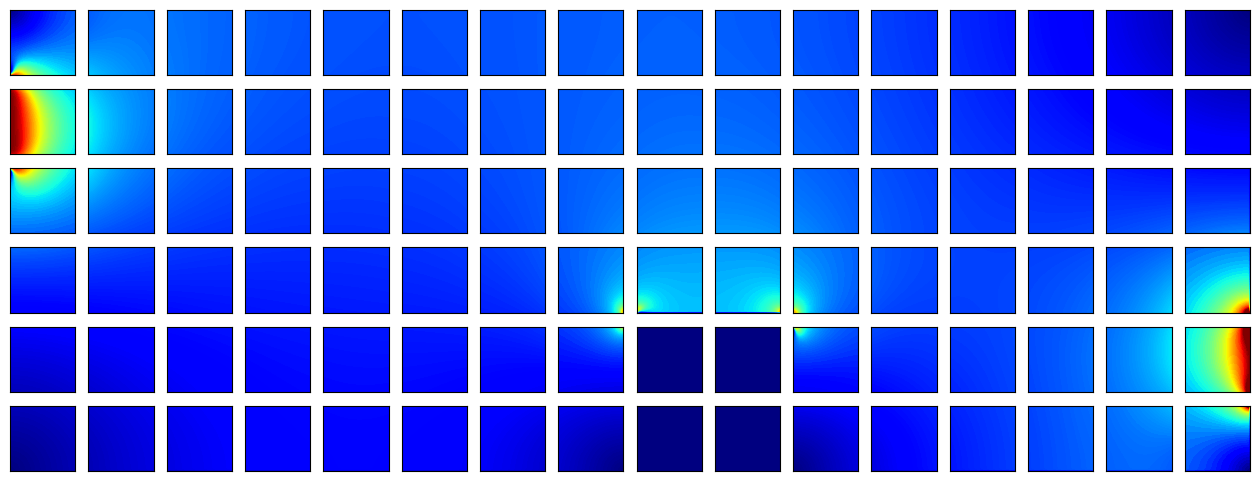

In [8]:
fig,axs = plt.subplots(6,16,figsize=(16,6))
# mag = np.empty((0,51,51))
# for batch in train_loader:
# 	train_bc, train_variable, train_coordinate, train_min, train_max = batch
# 	train_variable = train_variable.reshape(1, 599, 51, 51, 3)
# 	train_variable = dataset.inverse_normalize(train_variable,train_min,train_max)
# 	train_coordinate = train_coordinate.reshape(51, 51, 2)
	# mag = np.vstack((mag,np.sqrt(train_variable[:, 0, :, :, 0] ** 2 + train_variable[:, 0, :, :, 1] ** 2)))
print(mag_x.shape)
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(coordinate[0], coordinate[1], mag_x[i+j*6,:,:], 100, cmap='jet', vmin=0, vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])


plt.show()

(96, 51, 51)


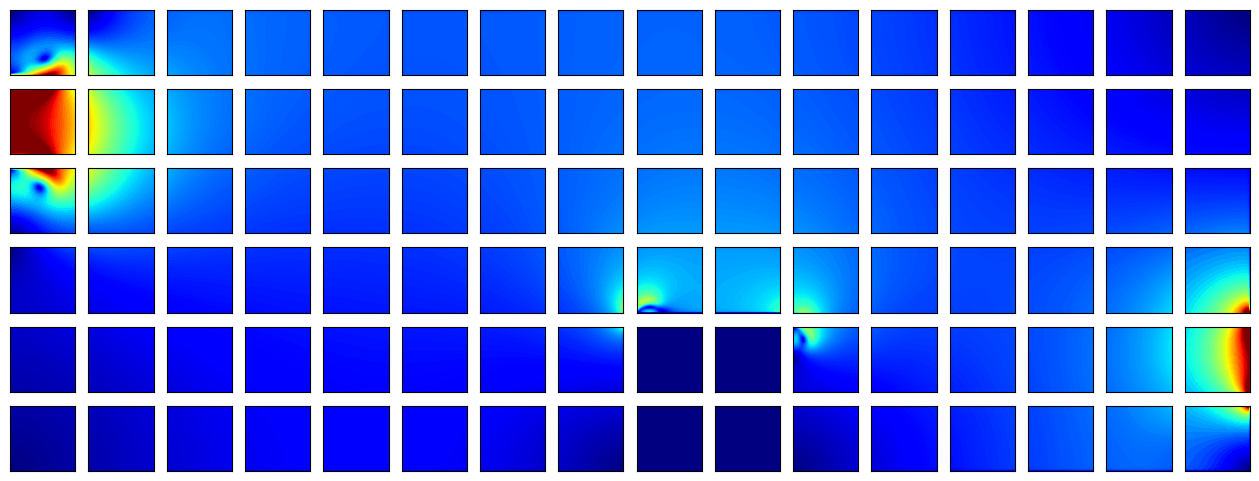

In [11]:
fig,axs = plt.subplots(6,16,figsize=(16,6))
print(mag_y.shape)
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(coordinate[0], coordinate[1], mag_y[i+j*6,:,:], 100, cmap='jet', vmin=0, vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])

拼接测试

In [3]:
load_path = r'transtant_model_state6800.pth'
load_model(load_path, optimizer, model)
model.to(device)
model.eval()
data_dir = r'I:\ML\Package_model\DeepONet\train_data\transtant'
datafile = r'I:\ML\Package_model\DeepONet\train_data\train_data.h5'
dataset = Dataset(data_dir,False,False,datafile)
# train_loader = DataLoader(dataset,batch_size=96,shuffle=False)
test_bc, test_variables, test_coordinates, test_min, test_max = dataset.getitem()
# print(np.tile(np.mean(test_bc[:,51:102,0],axis=1),(51,1)).T.shape)
# print(test_bc[:,51:102,0].shape)
# test_bc[:,51:102,0] = np.mean(np.mean(test_bc[:,51:102,0],axis=1),(51,1)).T
print(test_bc.shape)
print(test_coordinates.shape)
print(test_variables.shape)
print(test_min.shape)
print(test_max.shape)
# 查看归一化是否正确
print(torch.max(test_variables))

Load model at epoch: 6800


i:\ML\Package_model\DeepONet\transtant_model\DataGenerate.py:229: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  train_bc = torch.Tensor(self.bc)


torch.Size([599, 96, 204, 3])
torch.Size([2601, 2])
torch.Size([599, 96, 2601, 3])
torch.Size([599, 96, 3])
torch.Size([599, 96, 3])
tensor(40.7655)


In [78]:
test_bc = torch.from_numpy(test_bc).to(device)
test_coordinates = torch.from_numpy(test_coordinates).to(device)
test_variables = torch.from_numpy(test_variables).to(device)

In [4]:
def loss_func(output, label):
	mse_loss = nn.MSELoss()
	loss = mse_loss(output, label)
	return loss

In [5]:
time_step = 5
test_bc = test_bc[time_step,:,:,:].to(device)
test_variables = test_variables[time_step,:,:,:].to(device)
test_coordinates = test_coordinates.to(device)
test_min = test_min[time_step,:,:].to(device)
test_max = test_max[time_step,:,:].to(device)

In [6]:
with torch.no_grad():
	u_pred = model(test_bc[:,:,0],test_coordinates)
	v_pred = model(test_bc[:,:,1],test_coordinates)
	p_pred = model(test_bc[:,:,2],test_coordinates)
loss = loss_func(u_pred, test_variables[:,:,0]) + loss_func(v_pred, test_variables[:,:,1]) + loss_func(p_pred, test_variables[:,:,2])
print(loss.item())
u_pred = u_pred.cpu().detach().numpy().reshape(-1,51,51)
v_pred = v_pred.cpu().detach().numpy().reshape(-1,51,51)
p_pred = p_pred.cpu().detach().numpy().reshape(-1,51,51)
data = np.stack((u_pred,v_pred,p_pred),axis=3)
print(data.shape)
# 反归一化
data = data.reshape(1,-1,51,51,3)
test_min = test_min.cpu().detach().numpy().reshape(1,-1,3)
test_max = test_max.cpu().detach().numpy().reshape(1,-1,3)
inverse_data = dataset.inverse_normalize(data,test_min,test_max)
print(inverse_data.shape)

3.3801007383193555
(96, 51, 51, 3)
(1, 96, 51, 51, 3)


In [7]:
pred_index = 0
u_pred = inverse_data[:,:,:,:,0]
v_pred = inverse_data[:,:,:,:,1]
p_pred = inverse_data[:,:,:,:,2]
mag = np.sqrt(u_pred**2 + v_pred**2)
print(mag.shape)

(1, 96, 51, 51)


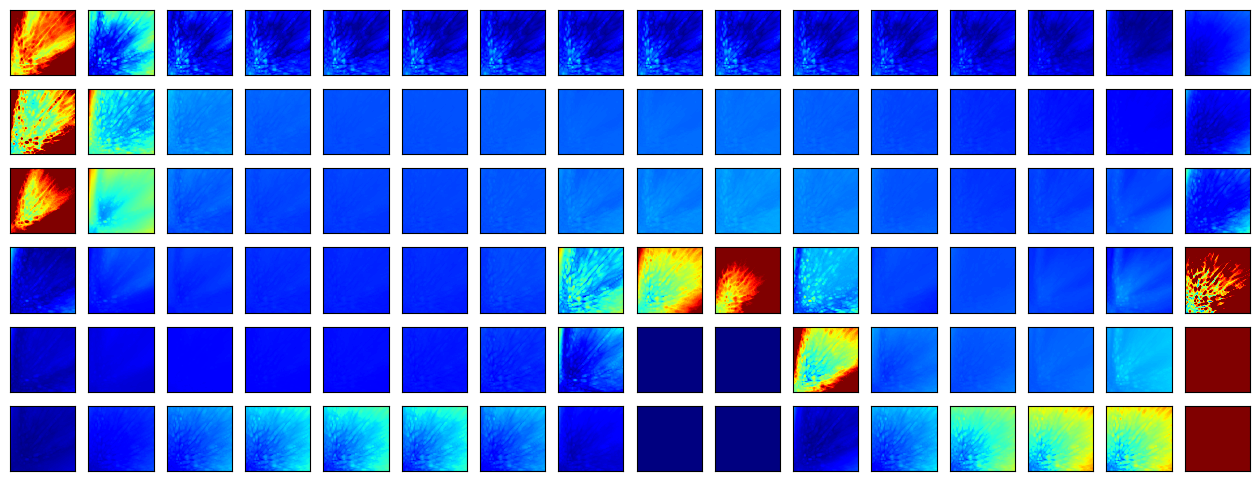

In [8]:
fig,axs = plt.subplots(6,16,figsize=(16,6))
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag[0,i+j*6,:,:], 100, cmap='jet', vmin=0, vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])
# plt.colorbar()

plt.show()

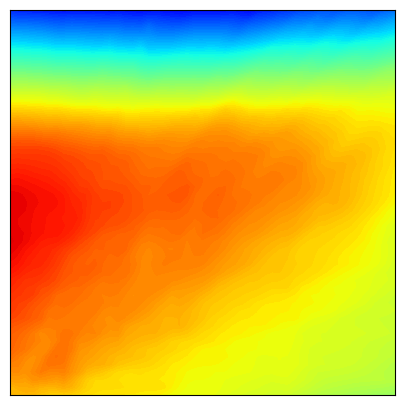

In [84]:
fig,axs = plt.subplots(1,1,figsize=(5,5))

axs.contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag[59,:,:], 100, cmap='jet', vmin=0, vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])
# plt.colorbar()

plt.show()

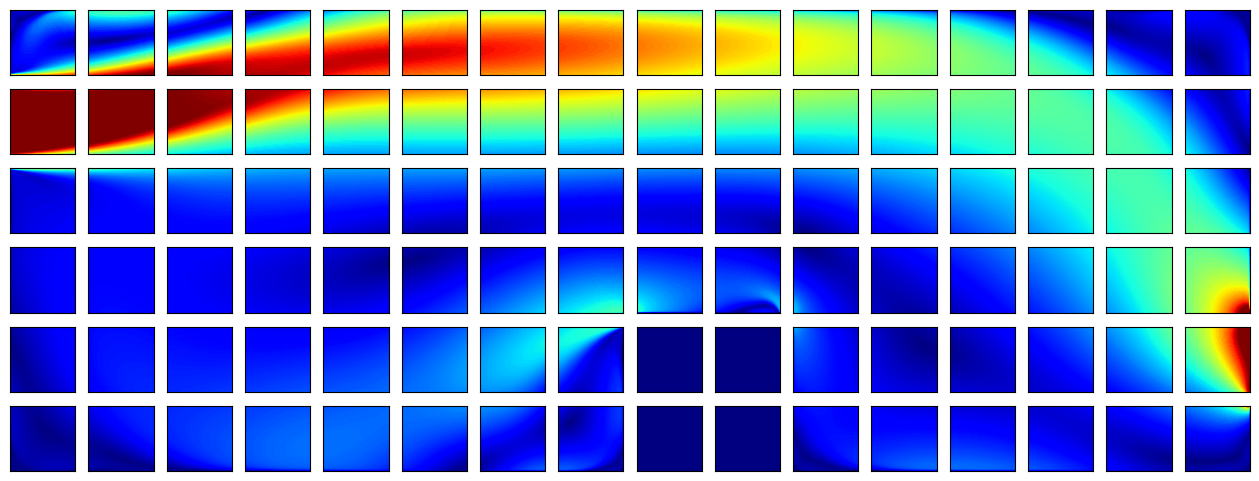

In [83]:
original_variables = test_variables.cpu().detach().numpy().reshape(-1,51,51,3)
original_data = dataset.inverse_normalize(original_variables,test_min,test_max)
u_original = original_data[:,:,:,0]
v_original = original_data[:,:,:,1]
p_original = original_data[:,:,:,2]

mag_original = np.sqrt(u_original**2 + v_original**2)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# contour = ax.contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag, 100, cmap='jet')
# plt.colorbar(contour)
# plt.show()
fig,axs = plt.subplots(6,16,figsize=(16,6))
for i in range(6):
	for j in range(16):
		axs[5-i,j].contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag_original[i+j*6,:,:], 100, cmap='jet', vmin=0, vmax=1)
		axs[5-i,j].set_aspect('equal')
		axs[5-i,j].set_xticks([])
		axs[5-i,j].set_yticks([])
plt.show()

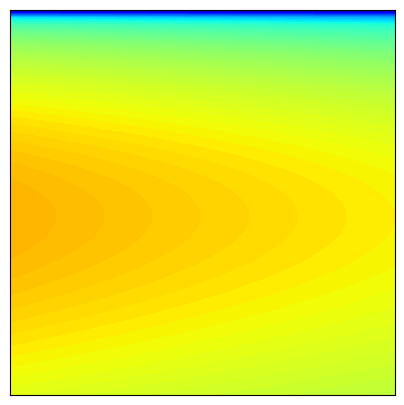

In [85]:
fig,axs = plt.subplots(1,1,figsize=(5,5))

axs.contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag_original[59,:,:], 100, cmap='jet', vmin=0, vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])
# plt.colorbar()

plt.show()

测试用流量守恒，水平流量全由水平方向流出，垂直方向全由垂直方向流出，边界设为平均值。测试位置：59

In [146]:
test_bc59 = test_bc.cpu().detach().numpy()[59:60,:,:]
print(test_bc59)

[[[0.86530974 0.02643614 0.71445357]
  [0.87443124 0.04316237 0.73273602]
  [0.88337736 0.06029634 0.75083857]
  [0.89213593 0.07783247 0.76872462]
  [0.90069423 0.09576399 0.78635558]
  [0.90903886 0.11408293 0.80369078]
  [0.91715574 0.13277995 0.82068738]
  [0.92503004 0.15184436 0.83730023]
  [0.93264608 0.17126399 0.85348174]
  [0.93998724 0.1910252  0.86918171]
  [0.94703585 0.21111272 0.8843471 ]
  [0.95377291 0.23150974 0.89892169]
  [0.96017789 0.25219776 0.91284575]
  [0.96622824 0.2731567  0.92605543]
  [0.97189882 0.29436482 0.93848201]
  [0.97716096 0.31579915 0.95005043]
  [0.98198174 0.337435   0.96067655]
  [0.98632424 0.35924556 0.97026562]
  [0.9901488  0.38120166 0.97871438]
  [0.99341383 0.40327165 0.98591462]
  [0.99607623 0.42542086 0.99175541]
  [0.99809162 0.44761206 0.99612423]
  [0.99941444 0.46980585 0.99890809]
  [0.99999861 0.49196056 0.99999552]
  [0.99979837 0.51403355 0.99927936]
  [0.99876922 0.53598088 0.99665905]
  [0.99686902 0.55775976 0.99204419]
 

In [147]:
test_bc59[:,102:153,0] = np.mean(test_bc59[:,:51,0],axis=1)
test_bc59[:,102:153,1] = np.mean(test_bc59[:,:51,1],axis=1)
test_bc59[:,102:153,2] = np.mean(test_bc59[:,:51,2],axis=1)

test_bc59[:,153:204,0] = np.mean(test_bc59[:,51:102,0],axis=1)
test_bc59[:,153:204,1] = np.mean(test_bc59[:,51:102,1],axis=1)
test_bc59[:,153:204,2] = np.mean(test_bc59[:,51:102,2],axis=1)

# test_bc59[:,102:153,0] = 0
# test_bc59[:,102:153,1] = 0
# test_bc59[:,102:153,2] = 0

# test_bc59[:,153:204,0] = 0
# test_bc59[:,153:204,1] = 0
# test_bc59[:,153:204,2] = 0

# test_bc59[:,102:153,0] = test_bc59[:,:51,0]
# test_bc59[:,102:153,1] = test_bc59[:,:51,1]
# test_bc59[:,102:153,2] = test_bc59[:,:51,2]

# test_bc59[:,153:204,0] = test_bc59[:,51:102,0]
# test_bc59[:,153:204,1] = test_bc59[:,51:102,1]
# test_bc59[:,153:204,2] = test_bc59[:,51:102,2]

In [148]:
test_bc59 = torch.from_numpy(test_bc59).to(device)
print(test_bc59.shape)

torch.Size([1, 204, 3])


In [149]:
with torch.no_grad():
	u_pred = model(test_bc59[:,:,0],test_coordinates)
	v_pred = model(test_bc59[:,:,1],test_coordinates)
	p_pred = model(test_bc59[:,:,2],test_coordinates)

In [150]:
loss = loss_func(u_pred, test_variables[59:60,:,0]) + loss_func(v_pred, test_variables[59:60,:,1]) + loss_func(p_pred, test_variables[59:60,:,2])
print(loss.item())

0.10678149389344511


In [151]:
u_pred = u_pred.cpu().detach().numpy().reshape(-1,51,51)
v_pred = v_pred.cpu().detach().numpy().reshape(-1,51,51)
p_pred = p_pred.cpu().detach().numpy().reshape(-1,51,51)
data = np.stack((u_pred,v_pred,p_pred),axis=3)
print(data.shape)
# 反归一化
inverse_data = dataset.inverse_normalize(data,test_min[59:60],test_max[59:60])

(1, 51, 51, 3)


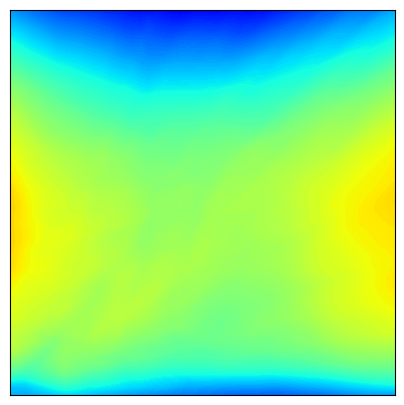

In [152]:
mag59 = np.sqrt(inverse_data[:,:,:,0]**2 + inverse_data[:,:,:,1]**2)
fig,axs = plt.subplots(1,1,figsize=(5,5))

axs.contourf(test_coordinates.cpu().detach().numpy()[:,0].reshape(51,51), test_coordinates.cpu().detach().numpy()[:,1].reshape(51,51), mag59[0], 100, cmap='jet', vmin=0, vmax=1)
axs.set_aspect('equal')
axs.set_xticks([])
axs.set_yticks([])
# plt.colorbar()

plt.show()

### 将距离函数分割

In [18]:
from DataGenerate import enhance_data

train_data = np.load(r'I:\ML\Package_model\DeepONet\FNO_distance\train_data\validation_distance_data.npy')
# truth_data = np.load(r'I:\ML\Package_model\DeepONet\FNO_distance\train_data\test_data_velocity.npy')
print(train_data.shape)
# print(truth_data.shape)

(96, 51, 51, 2)


In [19]:
train_data = train_data.reshape(16,6,51,51,2)
# truth_data = truth_data.reshape(16,6,51,51,1)
train_data_input = train_data[...,0]
train_data_boundary = train_data[...,1]
# truth_data = truth_data[...,0]
print(train_data_input.shape)
print(train_data_boundary.shape)
# print(truth_data.shape)

(16, 6, 51, 51)
(16, 6, 51, 51)


In [20]:
split = 4

x_original = np.empty((0, 51, 51))
y_original = np.empty((0, 51, 51))
u_original = np.empty((0, 51, 51))

for i in range(16-1):
	for j in range(6-1):
		for m in range(split):
			for n in range(split):
				x_temp0 = train_data_input[i,j,m*51//split:,n*51//split:]
				x_temp1 = train_data_input[i+1,j,m*51//split:,:n*51//split]
				x_temp2 = train_data_input[i,j+1,:m*51//split,n*51//split:]
				x_temp3 = train_data_input[i+1,j+1,:m*51//split,:n*51//split]
				x_temp01 = np.concatenate((x_temp0,x_temp1),axis = 1)
				x_temp23 = np.concatenate((x_temp2,x_temp3),axis = 1)
				x_temp = np.concatenate((x_temp01,x_temp23),axis = 0).reshape(1,51,51)
				x_original = np.vstack((x_original,x_temp))

				y_temp0 = train_data_boundary[i,j,m*51//split:,n*51//split:]
				y_temp1 = train_data_boundary[i+1,j,m*51//split:,:n*51//split]
				y_temp2 = train_data_boundary[i,j+1,:m*51//split,n*51//split:]
				y_temp3 = train_data_boundary[i+1,j+1,:m*51//split,:n*51//split]
				y_temp01 = np.concatenate((y_temp0,y_temp1),axis = 1)
				y_temp23 = np.concatenate((y_temp2,y_temp3),axis = 1)
				y_temp = np.concatenate((y_temp01,y_temp23),axis = 0).reshape(1,51,51)
				y_original = np.vstack((y_original,y_temp))

				# u_temp0 = truth_data[i,j,m*51//split:,n*51//split:]
				# u_temp1 = truth_data[i+1,j,m*51//split:,:n*51//split]
				# u_temp2 = truth_data[i,j+1,:m*51//split,n*51//split:]
				# u_temp3 = truth_data[i+1,j+1,:m*51//split,:n*51//split]
				# u_temp01 = np.concatenate((u_temp0,u_temp1),axis = 1)
				# u_temp23 = np.concatenate((u_temp2,u_temp3),axis = 1)
				# u_temp = np.concatenate((u_temp01,u_temp23),axis = 0).reshape(1,51,51)
				# u_original = np.vstack((u_original,u_temp))


In [21]:
train_data = np.stack((x_original,y_original),axis=-1)
# truth_data = u_original.reshape(-1,51,51,1)
print(train_data.shape)
print(truth_data.shape)

(1200, 51, 51, 2)
(1200, 51, 51, 1)


In [22]:
np.save(r'validation_distance_data_split_4.npy',train_data)
# np.save(r'test_data_velocity_split_4.npy',truth_data)